<a href="https://colab.research.google.com/github/jhmejia/deep-learning/blob/main/Transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Transfer Learning for Computer Vision Tutorial
==============================================

In this homework, you will train a CNN using two transfer learning approaches for the same image classification task. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. For deep learning, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

First we will need to download some external resources from GitHub. Run the cell below.


In [ ]:
!git clone https://github.com/tcuseniordesign/deep-learning-hw7-2.git

Cloning into 'deep-learning-hw7-2'...
remote: Enumerating objects: 407, done.
remote: Total 407 (delta 0), reused 0 (delta 0), pack-reused 407
Receiving objects: 100% (407/407), 45.03 MiB | 28.15 MiB/s, done.


Then we need to move the resources to the current directory. Run the cell below.

In [ ]:
import shutil
import os

source_dir = '/content/deep-learning-hw7-2'
target_dir = '/content/data'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

os.rmdir('/content/deep-learning-hw7-2')

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's visualize a few training images so as to understand the data augmentations.



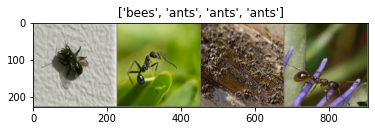

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Click "Runetime", then click "Change runtime type". Select "GPU" for Hardware accelerator. You can compare the speed between "GPU" and "CPU".

In [ ]:
num_classes = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Approach 1: Fine-tuning the CNN
----------------------

Load a pretrained model and reset the final fully connected (FC) layer. Read this section first: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks




In [ ]:
model_ft = models.resnet18(pretrained=True) # grab the resnet18 with the trained params from torchvision models
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # some literature calls loss function "criterion"

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5677 Acc: 0.7254
val Loss: 0.4307 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.4918 Acc: 0.8238
val Loss: 0.2628 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.6945 Acc: 0.7541
val Loss: 0.5332 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4499 Acc: 0.8402
val Loss: 0.1337 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.6213 Acc: 0.7623
val Loss: 0.1973 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4409 Acc: 0.8115
val Loss: 0.4073 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.4371 Acc: 0.8197
val Loss: 0.1983 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3798 Acc: 0.8279
val Loss: 0.1339 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3242 Acc: 0.8770
val Loss: 0.1382 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3707 Acc: 0.8484
val Loss: 0.1249 Acc: 0.9673

Epoch 10/24
----------
train Loss: 0.3557 Acc: 0.8443
val Loss: 0.1288 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2410 Acc: 0.8934
val Loss: 0.1309 Acc: 0.9608

Ep

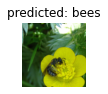

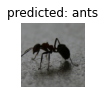

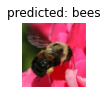

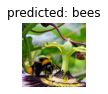

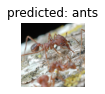

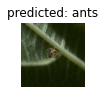

In [ ]:
visualize_model(model_ft)

Approach 2: ConvNet as fixed feature extractor
----------------------------------

In this approach, we don't bother retrain the entire CNN. We shall freeze all the  layers from resnet18 except the final one. We just need to train this new final layer. So, we need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    # Freeze all the prams (1 line)
    ### START CODE HERE

    ### END CODE HERE

# Parameters of newly constructed modules have requires_grad=True by default
# Replace the old final layer with a new final layer (2 lines)
### START CODE HERE


### END CODE HERE

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5791 Acc: 0.7008
val Loss: 0.2190 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.3557 Acc: 0.8238
val Loss: 0.2126 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4460 Acc: 0.8074
val Loss: 0.7312 Acc: 0.7124

Epoch 3/24
----------
train Loss: 0.4147 Acc: 0.8279
val Loss: 0.1655 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.2959 Acc: 0.8525
val Loss: 0.1511 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4808 Acc: 0.8033
val Loss: 0.1831 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5240 Acc: 0.7787
val Loss: 0.2985 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.4179 Acc: 0.8074
val Loss: 0.1773 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4265 Acc: 0.8156
val Loss: 0.1837 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3608 Acc: 0.8443
val Loss: 0.1861 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3436 Acc: 0.8607
val Loss: 0.1732 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2458 Acc: 0.8852
val Loss: 0.1798 Acc: 0.9477

Ep

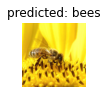

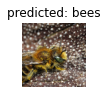

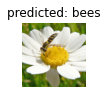

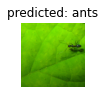

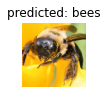

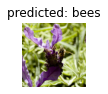

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()